In [1]:
# Import 
import os
import time
import json
import datetime
import sys

import pandas as pd
import numpy as np
from matplotlib import rcParams

from pathlib import Path
from tyssue import Sheet
from tyssue.io import hdf5

from tyssue.dynamics.sheet_gradients import height_grad
from tyssue.geometry import sheet_geometry
from tyssue.dynamics import units, effectors, model_factory
from tyssue.solvers.quasistatic import QSSolver
from tyssue.draw import sheet_view
import matplotlib.pyplot as plt
%matplotlib inline
rcParams['figure.dpi'] = 200

sys.path.append("..")
from peripodial.polarity import model
from peripodial.dynamics import EllipsoidLameGeometry as geom
from peripodial.anisotropy import anysotropy as aniso
from peripodial.anisotropy import face_orientation
from peripodial.polarity import update_weights
from peripodial.draw import draw_half_N_sheet

vispy  won't work


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
SIM_DIR = Path('/home/lglepin/Simulations/')
today = datetime.date.today()

sim_save_dir = SIM_DIR/f'{today.isoformat()}_YolkElasticity'

try:
    sim_save_dir.mkdir(parents=True, exist_ok=True)
except FileExistsError:
    pass

dsets = hdf5.load_datasets('../json_hdf5/lumen_elasticity.hdf5',
                               data_names=['vert', 'edge', 'face'])

with open('../json_hdf5/lumen_elasticity.json', 'r+') as fp:
    specs = json.load(fp)

sheet = Sheet('spherical', dsets)

sheet.update_specs(specs)
geom.update_all(sheet)


In [4]:
specs = {'face': {'prefered_perimeter': 3.8},
 'settings': {'geometry': 'spherical',
  'height_axis': 'z',
  'lumen_prefered_vol': 5700,
  'lumen_vol_elasticity': 0.01,
  'threshold_length': 0.01,
  'rosette_kwargs': {'threshold_length': 0.01, 'p_4': 0.01, 'p_5': 0.001},
  'barrier_radius': 13},
 'vert': {'barrier_elasticity': 280, 'delta_rho': 0},
        }

In [5]:
sheet.update_specs(specs, reset=True)
specs

{'face': {'prefered_perimeter': 3.8},
 'settings': {'geometry': 'spherical',
  'height_axis': 'z',
  'lumen_prefered_vol': 5700,
  'lumen_vol_elasticity': 0.01,
  'threshold_length': 0.01,
  'rosette_kwargs': {'threshold_length': 0.01, 'p_4': 0.01, 'p_5': 0.001},
  'barrier_radius': 13},
 'vert': {'barrier_elasticity': 280, 'delta_rho': 0}}

In [6]:
sheet.vert_df["delta_rho"] = sheet.settings["barrier_radius"]-sheet.vert_df["rho"]

In [7]:
sheet.vert_df

,x,y,z,is_active,rho,height,basal_shift,srce_o,radial_tension,unique_id,barrier_elasticity,viscosity,delta_rho
vert,,,,,,,,,,,,,
0,-1.337229,8.400666,-2.638139,1,8.906130,8.906130,4.0,0.000,0.0,0,280,0.1,4.093870
1,0.796772,8.489584,-1.026291,1,8.588432,8.588432,4.0,1.000,0.0,1,280,0.1,4.411568
2,-1.977101,8.267858,-1.059419,1,8.566725,8.566725,4.0,2.000,0.0,2,280,0.1,4.433275
3,-1.116566,8.438794,-1.598712,1,8.661168,8.661168,4.0,3.000,0.0,3,280,0.1,4.338832
4,-2.762881,8.082647,-2.748473,1,8.973115,8.973115,4.0,4.000,0.0,4,280,0.1,4.026885
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3295,5.435413,5.690134,8.288321,1,11.428806,11.428806,4.0,344.875,0.0,3295,280,0.1,1.571194
3296,4.717288,-6.378133,8.799046,1,11.847219,11.847219,4.0,442.500,0.0,3296,280,0.1,1.152781
3297,4.990228,-5.970929,9.594255,1,12.353303,12.353303,4.0,553.000,0.0,3297,280,0.1,0.646697


In [8]:
lumen_vol_egg= []
theta = np.pi / 3
bes = np.arange(0, 5e-1, 1e-1)
sheets_obj = {}
solver = QSSolver(with_t1=False, with_t3=False)
diameters = []
middle_dia_s = [] 
aniso_cell_values_d = []
radius=[]

for i, be in enumerate(bes):
    sheet_copy= sheet.copy()
    sheet_copy.vert_df['barrier_elasticity'] = be
    print(f"{i+1} / {10}", end=" ")
    res = solver.find_energy_min(sheet_copy, geom, model, options={"gtol": 1e-8})
    lumen_vol_egg.append(sheet_copy.settings['lumen_vol'])
    diameter = 2*(sheet_copy.vert_df["z"].max())
    sheets_obj[be] = sheet_copy
    diameters.append(diameter)
    center_verts =  sheet_copy.vert_df.loc[np.abs(sheet.vert_df["z"]) < 1]
    middle_dia = 2*(center_verts["x"]**2 + center_verts["y"]**2)**(0.5)
    middle_dia_s.append(middle_dia)
    sheet_copy.face_df['anisotropy'] = aniso(sheet_copy, coords = ['x','y','z'])
    center = np.abs(sheet_copy.face_df["z"]) < sheet_copy.face_df["z"].max()*0.75
    aniso_cell = sheet_copy.face_df.loc[center, 'anisotropy']
    aniso_cell_values_d.append(aniso_cell)
    radius.append(sheet_copy.settings['barrier_radius'])
    print(sheet_copy.settings['barrier_radius'])

lumen_vol_egg = np.array(diameters)
print(diameters)


1 / 10 13
2 / 10 13
3 / 10 13
4 / 10 13
5 / 10 13
[34.04149269586843, 33.62769482780227, 28.06526154990948, 27.903591408668824, 27.20927357007732]


In [9]:
bes = np.arange(0, 5e-1, 1e-1)

In [10]:
br = bes.tolist()

In [11]:
br

[0.0, 0.1, 0.2, 0.30000000000000004, 0.4]

<function matplotlib.pyplot.show(close=None, block=None)>

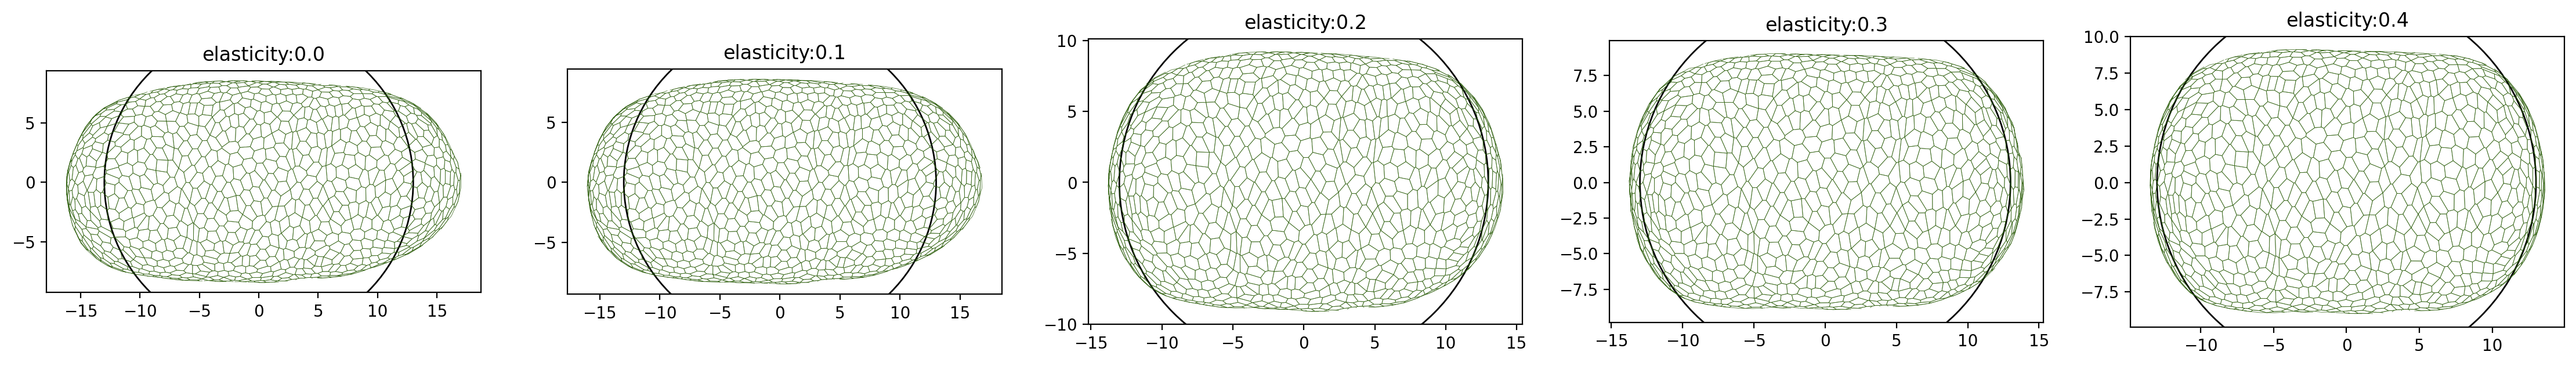

In [12]:
fig, axes = plt.subplots(1, len(sheets_obj), figsize=(28,8))

for i, (bes, sheet_copy) in enumerate(sheets_obj.items()):
    #plt.savefig(f'sheet {i+1}.png', transparent=True)
    fig, ax = draw_half_N_sheet(sheet_copy, axes[i], coords = ["z", "x"])
    circle = plt.Circle((0, 0), radius[i], edgecolor='black', facecolor='none')
    ax.add_artist(circle)
    ax.set_title('elasticity:{:.1f}'.format(br[i]))
    ax.set_facecolor('#ffffff')
plt.savefig('../image/barrier_elasticity.png', transparent=False)
plt.show


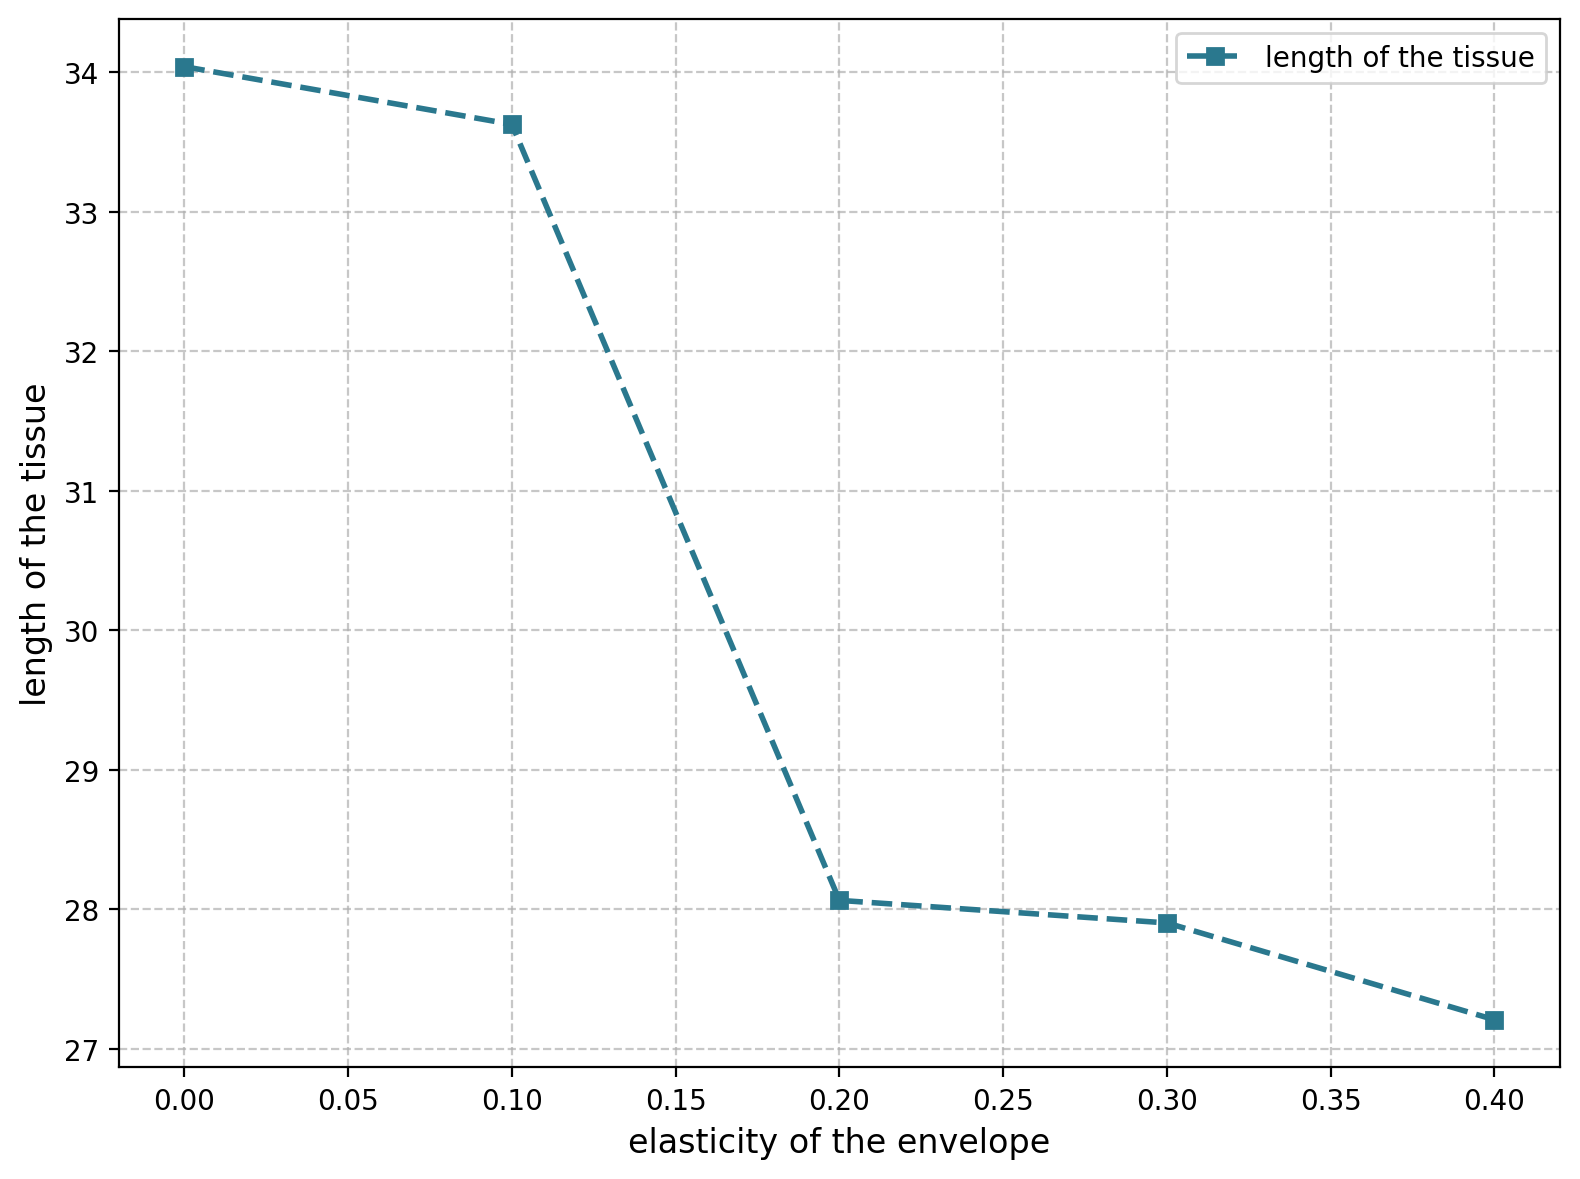

In [13]:
colors = plt.cm.viridis_r([0.2, 0.6])
fig, axs = plt.subplots(1, figsize=(8, 6))
axs.plot(br, diameters, label='length of the tissue', color=colors[1], marker='s', linestyle='--', linewidth=2)
#axs.set_xscale('log')
axs.set_xlabel('elasticity of the envelope', fontsize=12)
axs.set_ylabel('length of the tissue', fontsize=12)
axs.grid(True, linestyle='--', alpha=0.7)
axs.legend(loc='best', fontsize=10)
plt.tight_layout()
plt.savefig('../image/tissue_length_barrier_elasticity_lumen.png', transparent=False)
plt.show()

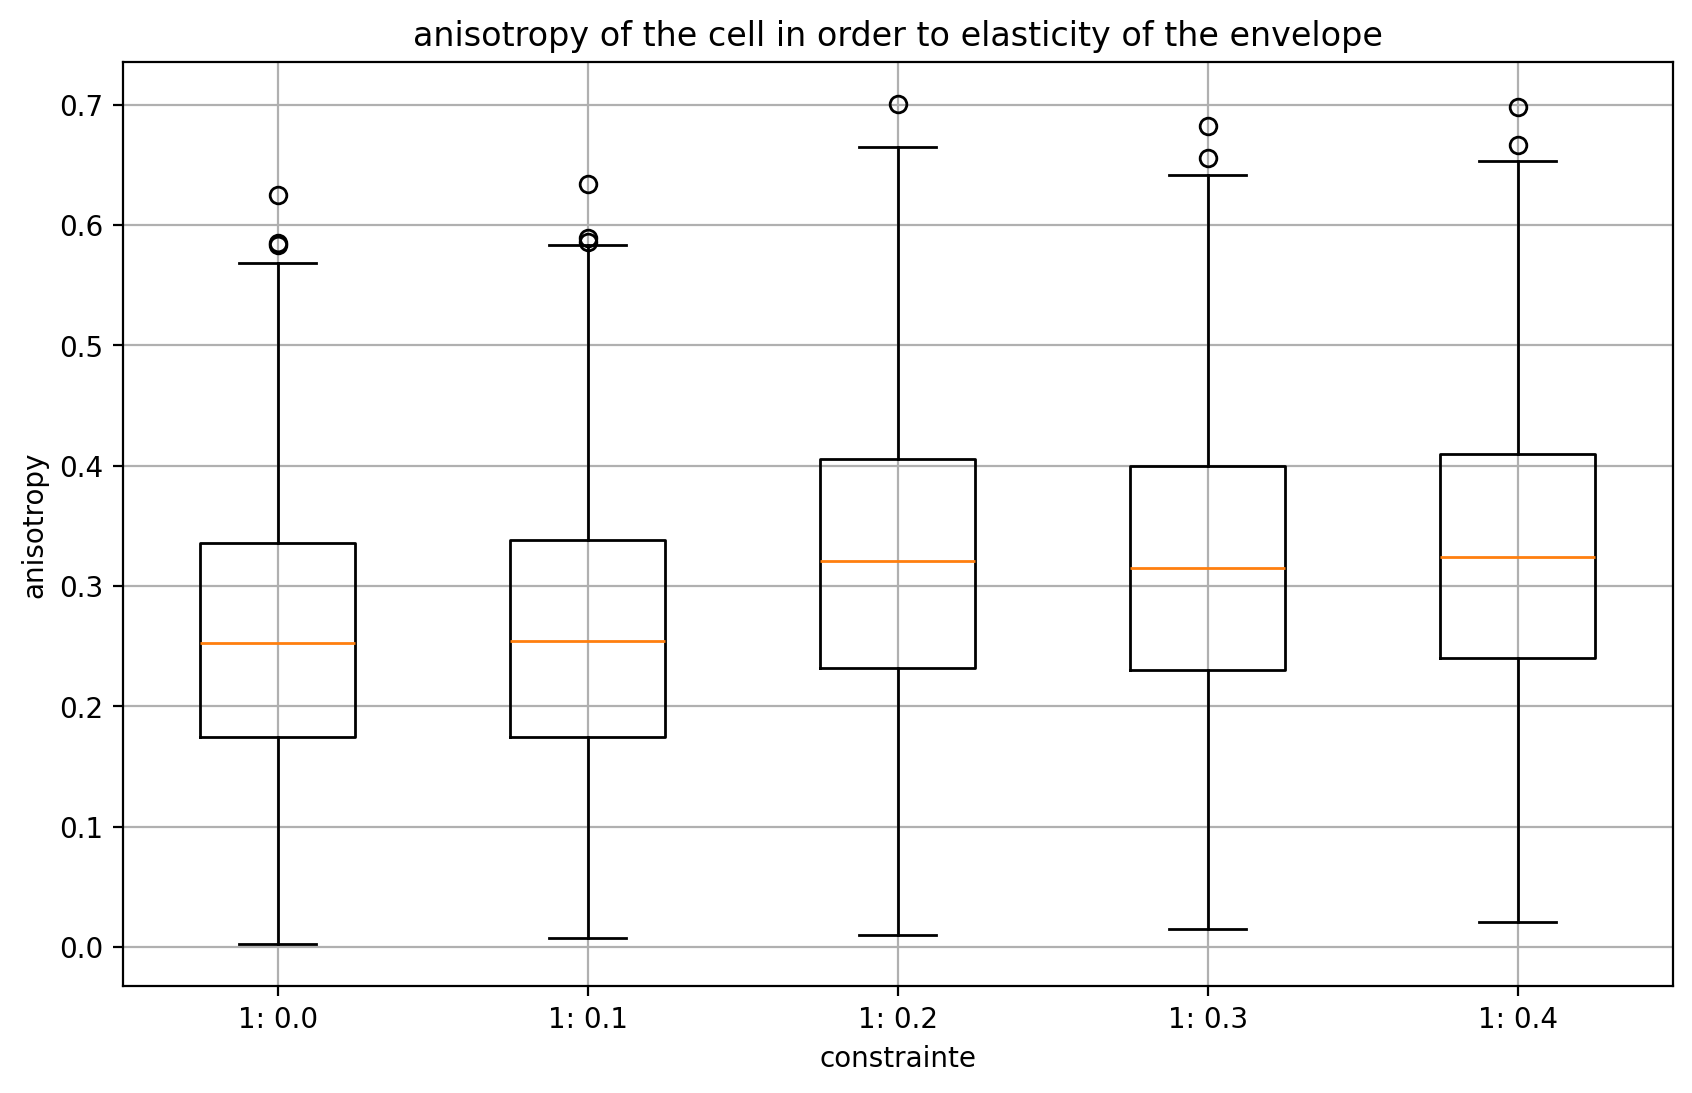

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.boxplot(aniso_cell_values_d)
plt.title('anisotropy of the cell in order to elasticity of the envelope')
plt.xlabel('constrainte')
plt.ylabel('anisotropy')
plt.xticks(range(1, len(aniso_cell_values_d) + 1), ['1: {:.1f}'.format(i) for i in br])
plt.grid(True)
plt.savefig('../image/plot_aniso_constraint.png', transparent=False)
plt.show()